Running on: cuda


100%|██████████| 26.4M/26.4M [00:03<00:00, 8.21MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 206kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.81MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.8MB/s]


Training Started...
Epoch 1/20  D:0.5183  G:11.7537  Base:0.2443
Epoch 2/20  D:0.1200  G:16.8174  Base:0.1818
Epoch 3/20  D:0.1700  G:13.5709  Base:0.1532
Epoch 4/20  D:0.7143  G:11.0631  Base:0.1452
Epoch 5/20  D:0.5561  G:12.7225  Base:0.1790
Epoch 6/20  D:0.3343  G:10.3157  Base:0.1461
Epoch 7/20  D:0.6515  G:11.1998  Base:0.1811
Epoch 8/20  D:0.3564  G:10.9040  Base:0.1894
Epoch 9/20  D:0.1376  G:9.7585  Base:0.1914
Epoch 10/20  D:1.2084  G:10.0655  Base:0.1821
Epoch 11/20  D:0.3073  G:8.7843  Base:0.1531
Epoch 12/20  D:0.1131  G:11.0073  Base:0.1766
Epoch 13/20  D:0.3921  G:11.3285  Base:0.1468
Epoch 14/20  D:0.2234  G:8.7529  Base:0.1542
Epoch 15/20  D:0.4842  G:8.5395  Base:0.1666
Epoch 16/20  D:0.1941  G:7.8973  Base:0.1399
Epoch 17/20  D:0.2294  G:7.1976  Base:0.1471
Epoch 18/20  D:0.2659  G:7.0771  Base:0.1807
Epoch 19/20  D:0.1639  G:8.2339  Base:0.1405
Epoch 20/20  D:0.1310  G:8.2052  Base:0.1375
Training Completed


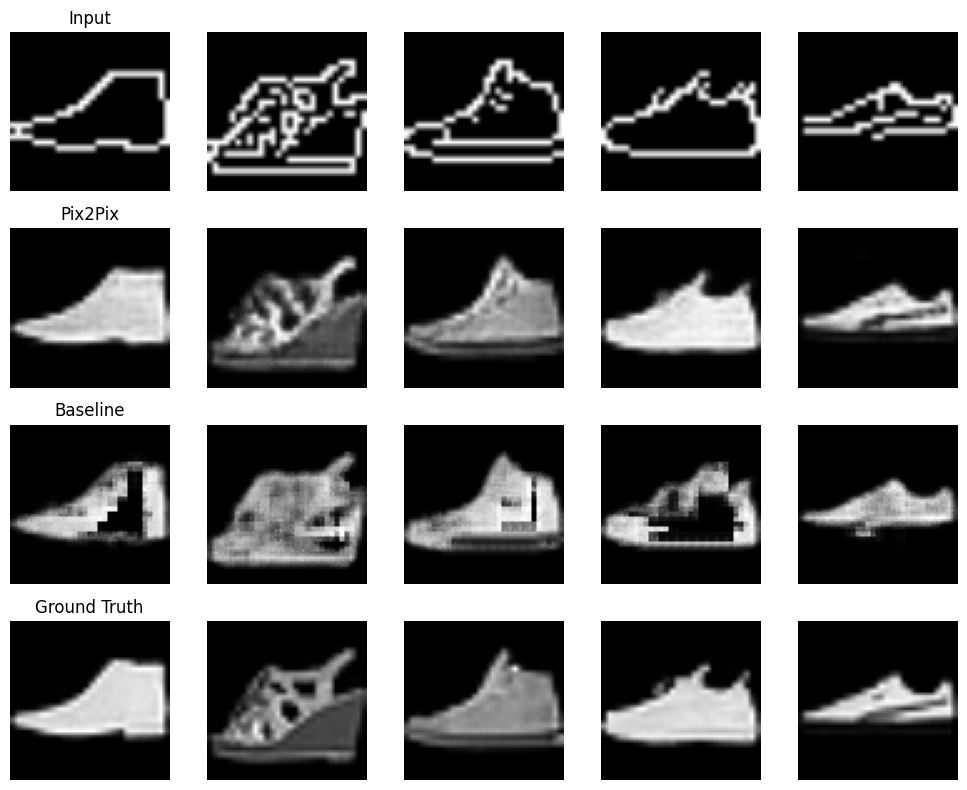

In [1]:
# ==============================
# FULL PIX2PIX LAB IMPLEMENTATION
# ==============================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ==============================
# CONFIG
# ==============================
BATCH_SIZE = 64
EPOCHS = 20
LR = 0.0002
LAMBDA_L1 = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Running on: {DEVICE}")

# ==============================
# DATASET (Simulated Edges2Shoes)
# ==============================
class SimulatedEdges2ShoesDataset(Dataset):
    def __init__(self, root='./data', train=True):
        self.transform = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        full_ds = torchvision.datasets.FashionMNIST(
            root=root, train=train, download=True
        )

        # use some classes as "shoes"
        self.data = [img for img, label in full_ds if label in [5,7,9]]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        real_img_pil = self.data[idx]
        real_img = self.transform(real_img_pil)

        img_np = np.array(real_img_pil)
        edges = cv2.Canny(img_np, 100, 200)
        edges = transforms.ToPILImage()(edges)
        edge_img = self.transform(edges)

        return edge_img, real_img


train_ds = SimulatedEdges2ShoesDataset(train=True)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

# ==============================
# U-NET GENERATOR
# ==============================
class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = self.conv_block(1, 64, bn=False)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.bottleneck = self.conv_block(512, 512)

        self.dec4 = self.up_block(512, 512)
        self.dec3 = self.up_block(1024, 256)
        self.dec2 = self.up_block(512, 128)
        self.dec1 = self.up_block(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 1, 4, 2, 1),
            nn.Tanh()
        )

    def conv_block(self, in_c, out_c, bn=True):
        layers = [nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False)]
        if bn:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)

    def up_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        b = self.bottleneck(e4)

        d4 = self.dec4(b)
        d4 = torch.cat((d4, e4), dim=1)

        d3 = self.dec3(d4)
        d3 = torch.cat((d3, e3), dim=1)

        d2 = self.dec2(d3)
        d2 = torch.cat((d2, e2), dim=1)

        d1 = self.dec1(d2)
        d1 = torch.cat((d1, e1), dim=1)

        return self.final(d1)

# ==============================
# PATCHGAN DISCRIMINATOR
# ==============================
class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(2, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 1, 4, 1, 1)
        )

    def forward(self, img_A, img_B):
        x = torch.cat((img_A, img_B), 1)
        return self.model(x)

# ==============================
# BASELINE CNN (NO GAN)
# ==============================
class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# ==============================
# INITIALIZE
# ==============================
generator = UNetGenerator().to(DEVICE)
discriminator = PatchGANDiscriminator().to(DEVICE)
baseline = BaselineCNN().to(DEVICE)

optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_base = optim.Adam(baseline.parameters(), lr=LR)

adversarial_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

# ==============================
# TRAINING
# ==============================
print("Training Started...")

for epoch in range(EPOCHS):
    for edge_img, real_img in train_loader:

        edge_img = edge_img.to(DEVICE)
        real_img = real_img.to(DEVICE)

        valid = torch.ones((edge_img.size(0), 1, 7, 7), device=DEVICE)
        fake = torch.zeros((edge_img.size(0), 1, 7, 7), device=DEVICE)

        # ---- Train Generator ----
        optimizer_G.zero_grad()
        fake_img = generator(edge_img)
        pred_fake = discriminator(edge_img, fake_img)
        loss_GAN = adversarial_loss(pred_fake, valid)
        loss_pixel = l1_loss(fake_img, real_img)
        loss_G = loss_GAN + LAMBDA_L1 * loss_pixel
        loss_G.backward()
        optimizer_G.step()

        # ---- Train Discriminator ----
        optimizer_D.zero_grad()
        pred_real = discriminator(edge_img, real_img)
        loss_real = adversarial_loss(pred_real, valid)

        pred_fake = discriminator(edge_img, fake_img.detach())
        loss_fake = adversarial_loss(pred_fake, fake)

        loss_D = 0.5 * (loss_real + loss_fake)
        loss_D.backward()
        optimizer_D.step()

        # ---- Train Baseline ----
        optimizer_base.zero_grad()
        base_out = baseline(edge_img)
        loss_base = l1_loss(base_out, real_img)
        loss_base.backward()
        optimizer_base.step()

    print(f"Epoch {epoch+1}/{EPOCHS}  D:{loss_D.item():.4f}  G:{loss_G.item():.4f}  Base:{loss_base.item():.4f}")

print("Training Completed")

# ==============================
# VISUALIZATION
# ==============================
generator.eval()
baseline.eval()

test_loader = DataLoader(train_ds, batch_size=5, shuffle=True)
edge_sample, real_sample = next(iter(test_loader))
edge_sample = edge_sample.to(DEVICE)

with torch.no_grad():
    fake_sample = generator(edge_sample).cpu()
    base_sample = baseline(edge_sample).cpu()

fig, axs = plt.subplots(4, 5, figsize=(10, 8))

for i in range(5):
    axs[0, i].imshow(edge_sample[i].cpu().squeeze(), cmap='gray')
    axs[0, i].axis('off')
    if i == 0: axs[0, i].set_title("Input")

    axs[1, i].imshow(fake_sample[i].squeeze(), cmap='gray')
    axs[1, i].axis('off')
    if i == 0: axs[1, i].set_title("Pix2Pix")

    axs[2, i].imshow(base_sample[i].squeeze(), cmap='gray')
    axs[2, i].axis('off')
    if i == 0: axs[2, i].set_title("Baseline")

    axs[3, i].imshow(real_sample[i].squeeze(), cmap='gray')
    axs[3, i].axis('off')
    if i == 0: axs[3, i].set_title("Ground Truth")

plt.tight_layout()
plt.show()